# Clustering, Modeling and Visualizing Features

We will be using a 1700+ row dataset collected from the Spotify API and consisting of songs from a playlist from DJ and producer Four Tet, which can be found in the above CSV file. The dataset consists of descriptive metadata (track name, artist name) as well as numerical audio features which we will use for modeling (acousticness, danceability, duration, energy, instrumentalness, liveness, loudness, tempo and valence).

After fitting our model we will test it on two additional smaller playlists: Spotify's "Songs to Sing in the Shower" (200 rows) and Max Richter's "Kitchen Playlist" (78 songs).

Below we will import modules to be used.

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, make_scorer,plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
%matplotlib inline
from lime import lime_tabular

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/metrics/__init__.py)

In [2]:
df = pd.read_csv('fourtet.csv')
df.head()

,Unnamed: 0,track_name,album,artist_name,release_date,duration_ms,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,My Friend of Misery - From Jason's Riff Tapes,Metallica (Remastered Deluxe Box Set),Metallica,2021-09-10,277892,42,0.750,0.874,0.2100,0.9420,0.111,-19.358,0.0368,109.650,0.4990
1,1,Magnet Pulls Through,Tortoise,Tortoise,1994-09-01,278040,22,0.541,0.133,0.2450,0.7950,0.110,-17.452,0.0339,68.398,0.0435
2,2,Houston in Two Seconds,Music by Ry Cooder,Ry Cooder,1995,121826,32,0.256,0.917,0.0458,0.0419,0.125,-23.396,0.0602,171.818,0.1200
3,3,Lost in A Lonely World,The Best of the Ethics,The Ethics,2003-01-01,154866,40,0.504,0.920,0.1160,0.0706,0.103,-11.122,0.0351,105.175,0.1950
4,4,Conducted Rhythms,Peanut Butter Wolf's Jukebox 45's,Various Artists,2002-09-01,111000,0,0.827,0.323,0.4720,0.6160,0.560,-7.085,0.3300,105.942,0.8200


Importing DataFrame and checking for null values and descriptive statistics.

In [3]:
df.isna().sum()

Unnamed: 0          0
track_name          0
album               0
artist_name         0
release_date        0
duration_ms         0
popularity          0
danceability        0
acousticness        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

In [4]:
df.describe()

,Unnamed: 0,duration_ms,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,1749.000000,1.749000e+03,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000,1749.000000
mean,874.000000,3.025054e+05,14.173814,0.573177,0.422119,0.536230,0.504110,0.163499,-12.556360,0.097535,119.239222,0.426432
std,505.037127,1.791806e+05,15.253037,0.202864,0.368637,0.257424,0.389365,0.137297,5.646474,0.109528,27.410275,0.275130
min,0.000000,1.895700e+04,0.000000,0.000000,0.000002,0.000281,0.000000,0.020600,-37.114000,0.000000,0.000000,0.000000
25%,437.000000,1.920000e+05,0.000000,0.426000,0.047700,0.343000,0.018900,0.090200,-15.286000,0.040200,99.956000,0.178000
50%,874.000000,2.710530e+05,9.000000,0.595000,0.334000,0.560000,0.656000,0.111000,-11.315000,0.056200,121.008000,0.398000
75%,1311.000000,3.676640e+05,23.000000,0.745000,0.805000,0.749000,0.880000,0.172000,-8.498000,0.099500,133.994000,0.660000
max,1748.000000,2.241200e+06,71.000000,0.980000,0.996000,0.999000,0.984000,0.993000,-1.987000,0.947000,210.029000,0.996000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1749 non-null   int64  
 1   track_name        1749 non-null   object 
 2   album             1749 non-null   object 
 3   artist_name       1749 non-null   object 
 4   release_date      1749 non-null   object 
 5   duration_ms       1749 non-null   int64  
 6   popularity        1749 non-null   int64  
 7   danceability      1749 non-null   float64
 8   acousticness      1749 non-null   float64
 9   energy            1749 non-null   float64
 10  instrumentalness  1749 non-null   float64
 11  liveness          1749 non-null   float64
 12  loudness          1749 non-null   float64
 13  speechiness       1749 non-null   float64
 14  tempo             1749 non-null   float64
 15  valence           1749 non-null   float64
dtypes: float64(9), int64(3), object(4)
memory 

Not being an audio feature, we can drop the 'popularity' column.

In [6]:
df = df.drop(['popularity', 'Unnamed: 0'], axis=1)
df

,track_name,album,artist_name,release_date,duration_ms,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,My Friend of Misery - From Jason's Riff Tapes,Metallica (Remastered Deluxe Box Set),Metallica,2021-09-10,277892,0.750,0.87400,0.21000,0.9420,0.1110,-19.358,0.0368,109.650,0.4990
1,Magnet Pulls Through,Tortoise,Tortoise,1994-09-01,278040,0.541,0.13300,0.24500,0.7950,0.1100,-17.452,0.0339,68.398,0.0435
2,Houston in Two Seconds,Music by Ry Cooder,Ry Cooder,1995,121826,0.256,0.91700,0.04580,0.0419,0.1250,-23.396,0.0602,171.818,0.1200
3,Lost in A Lonely World,The Best of the Ethics,The Ethics,2003-01-01,154866,0.504,0.92000,0.11600,0.0706,0.1030,-11.122,0.0351,105.175,0.1950
4,Conducted Rhythms,Peanut Butter Wolf's Jukebox 45's,Various Artists,2002-09-01,111000,0.827,0.32300,0.47200,0.6160,0.5600,-7.085,0.3300,105.942,0.8200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,Es war einmal,Sowiesoso,Cluster,1976,325400,0.643,0.75800,0.15600,0.9760,0.1040,-20.074,0.0419,117.372,0.3140
1745,Kinoshita,Eph Reissue,Fridge,2002-05-07,302693,0.623,0.13200,0.94500,0.8950,0.3020,-5.775,0.0984,139.971,0.6110
1746,Promises Of Fertility,For Those Of You Who Have Never (And Also Thos...,Huerco S.,2016-06-10,415933,0.260,0.82100,0.28400,0.8410,0.1100,-19.656,0.0367,61.829,0.4250
1747,3,Get Out,Pita,2008-05-12,678080,0.228,0.00869,0.61900,0.9280,0.1540,-7.414,0.0483,105.538,0.2070


We will select our numerical values for modeling and store them in the variable X.

In [7]:
X = df.select_dtypes(np.number)
X

,duration_ms,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,277892,0.750,0.87400,0.21000,0.9420,0.1110,-19.358,0.0368,109.650,0.4990
1,278040,0.541,0.13300,0.24500,0.7950,0.1100,-17.452,0.0339,68.398,0.0435
2,121826,0.256,0.91700,0.04580,0.0419,0.1250,-23.396,0.0602,171.818,0.1200
3,154866,0.504,0.92000,0.11600,0.0706,0.1030,-11.122,0.0351,105.175,0.1950
4,111000,0.827,0.32300,0.47200,0.6160,0.5600,-7.085,0.3300,105.942,0.8200
...,...,...,...,...,...,...,...,...,...,...
1744,325400,0.643,0.75800,0.15600,0.9760,0.1040,-20.074,0.0419,117.372,0.3140
1745,302693,0.623,0.13200,0.94500,0.8950,0.3020,-5.775,0.0984,139.971,0.6110
1746,415933,0.260,0.82100,0.28400,0.8410,0.1100,-19.656,0.0367,61.829,0.4250
1747,678080,0.228,0.00869,0.61900,0.9280,0.1540,-7.414,0.0483,105.538,0.2070


With KMeans we can find the optimal number of clusters using the elbow method.

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/p

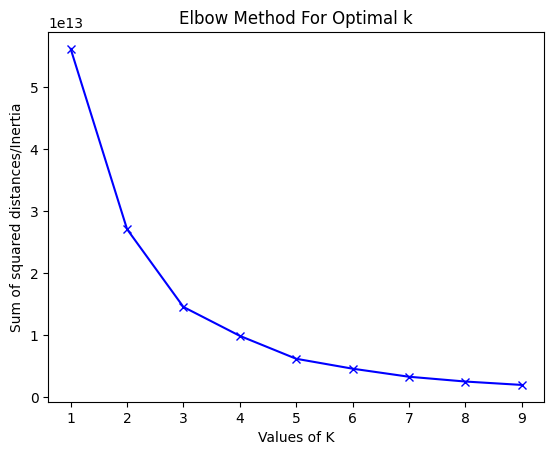

In [8]:
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

It appears the optimal K is right around 3 so we will scale and fit our numeric data.

In [9]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=3, verbose=2))])
cluster_pipeline.fit(X)

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 16819.815213959773.
Iteration 1, inertia 13365.032093730795.
Iteration 2, inertia 12927.236660250837.
Iteration 3, inertia 12678.05788629841.
Iteration 4, inertia 12470.470845200938.
Iteration 5, inertia 12359.263788244298.
Iteration 6, inertia 12297.977093355312.
Iteration 7, inertia 12277.21890167495.
Iteration 8, inertia 12271.607206747773.
Iteration 9, inertia 12269.84772518089.
Iteration 10, inertia 12269.551847964525.
Converged at iteration 10: center shift 5.241137586564755e-05 within tolerance 9.999999999999995e-05.
Initialization complete
Iteration 0, inertia 16944.525669432034.
Iteration 1, inertia 12726.453710887843.
Iteration 2, inertia 12378.0657202408.
Iteration 3, inertia 12297.525130333503.
Iteration 4, inertia 12276.608152511393.
Iteration 5, inertia 12270.765267417788.
Iteration 6, inertia 12269.476115447.
Iteration 7, inertia 12269.371356807602.
Converged at iteration 7: center shift 4.457618835207537e-05 within tolerance 

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, verbose=2))])

In [10]:
cluster_labels = cluster_pipeline.predict(X)
df['cluster'] = cluster_labels
df['cluster'].value_counts()

1    660
2    555
0    534
Name: cluster, dtype: int64

We have three similarly sized clusters. We can reduce dimentionality using Principal Component Analysis, fit and visualize our data using a Plotly hover plot. 

In [11]:
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = df['track_name']
projection['artist'] = df['artist_name']
projection['cluster'] = df['cluster']
projection

,x,y,title,artist,cluster
0,1.635548,0.379433,My Friend of Misery - From Jason's Riff Tapes,Metallica,2
1,1.619235,0.650001,Magnet Pulls Through,Tortoise,2
2,3.067929,-0.495287,Houston in Two Seconds,Ry Cooder,2
3,1.800525,-0.976904,Lost in A Lonely World,The Ethics,2
4,-1.631911,-2.611840,Conducted Rhythms,Various Artists,0
...,...,...,...,...,...
1744,2.006184,0.849126,Es war einmal,Cluster,2
1745,-2.093137,0.626861,Kinoshita,Fridge,1
1746,2.736273,0.174917,Promises Of Fertility,Huerco S.,2
1747,-0.030471,2.012045,3,Pita,1


In [12]:
fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig.show()

We can proceed to build a content-based recommendation system, however let's repeat the process with two clusters and visualize our results to see if we can build a clasifier and identify the model's most important features.

In [13]:
cluster_pipeline2 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2, verbose=2))])
cluster_pipeline2.fit(X)

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Initialization complete
Iteration 0, inertia 29992.558763563382.
Iteration 1, inertia 15109.3567920417.
Iteration 2, inertia 13932.36864587519.
Iteration 3, inertia 13732.201138402846.
Iteration 4, inertia 13715.223047383734.
Iteration 5, inertia 13713.913364561779.
Iteration 6, inertia 13713.742544089091.
Converged at iteration 6: center shift 3.488840593549428e-05 within tolerance 9.999999999999995e-05.
Initialization complete
Iteration 0, inertia 21352.74168520058.
Iteration 1, inertia 13882.394629386205.
Iteration 2, inertia 13730.22753297869.
Iteration 3, inertia 13715.257869378282.
Iteration 4, inertia 13713.862303620635.
Iteration 5, inertia 13713.742544089091.
Converged at iteration 5: center shift 3.488840593549424e-05 within tolerance 9.999999999999995e-05.
Initialization complete
Iteration 0, inertia 19243.697120034034.
Iteration 1, inertia 14699.822838231281.
Iteration 2, inertia 14105.063197128718.
Iteration 3, inertia 13791.567278553384.
Iteration 4, inertia 13727.1266036

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=2, verbose=2))])

In [14]:
cluster_labels2 = cluster_pipeline2.predict(X)
df['cluster2'] = cluster_labels2
df['cluster2'].value_counts()

1    1140
0     609
Name: cluster2, dtype: int64

In [15]:
pca_pipeline2 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding2 = pca_pipeline2.fit_transform(X)
projection2 = pd.DataFrame(columns=['x', 'y'], data=song_embedding2)
projection2['title'] = df['track_name']
projection2['artist'] = df['artist_name']
projection2['cluster2'] = df['cluster2']
projection2

,x,y,title,artist,cluster2
0,1.635548,0.379433,My Friend of Misery - From Jason's Riff Tapes,Metallica,0
1,1.619235,0.650001,Magnet Pulls Through,Tortoise,0
2,3.067929,-0.495287,Houston in Two Seconds,Ry Cooder,0
3,1.800525,-0.976904,Lost in A Lonely World,The Ethics,0
4,-1.631911,-2.611840,Conducted Rhythms,Various Artists,1
...,...,...,...,...,...
1744,2.006184,0.849126,Es war einmal,Cluster,0
1745,-2.093137,0.626861,Kinoshita,Fridge,1
1746,2.736273,0.174917,Promises Of Fertility,Huerco S.,0
1747,-0.030471,2.012045,3,Pita,1


In [16]:
fig2 = px.scatter(projection2, x='x', y='y', color='cluster2', hover_data=['x', 'y', 'title', 'artist'])
fig2.show()

While our sample sizes are imbalanced, our cluster on the positive x-axis remains similar. A binary classification model focusing on accuracy can pinpoint which audio features are most important.

In [17]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster', 'cluster2'], axis=1)
predictor_y = df.cluster2

In [18]:
def print_metrics(labels, preds):
    
    # Function to easily print results of training and test metrics
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [19]:
# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()
smote = SMOTE()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
pipeline = make_pipeline(scaler, smote, logreg)
pipeline.fit(X_train_resampled, y_train_resampled)
train_pred = pipeline.predict(X_train_resampled)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train_resampled, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9795081967213114
Test Score:  0.9815973500184026


In [20]:
print("Training Metrics")
print(print_metrics(y_train_resampled, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.9734104046242774
Recall Score: 0.9859484777517564
Accuracy Score: 0.9795081967213115
F1 Score: 0.9796393251890633
None


Testing Metrics
Precision Score: 0.9860627177700348
Recall Score: 0.9895104895104895
Accuracy Score: 0.9840182648401826
F1 Score: 0.987783595113438
None


In [21]:
print("Confusion Matrices - Training and Test Sets")
plot_confusion_matrix(pipeline, X_train_resampled, y_train_resampled, cmap=plt.cm.Blues, values_format='.3g')
plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

Confusion Matrices - Training and Test Sets


NameError: name 'plot_confusion_matrix' is not defined

In [24]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

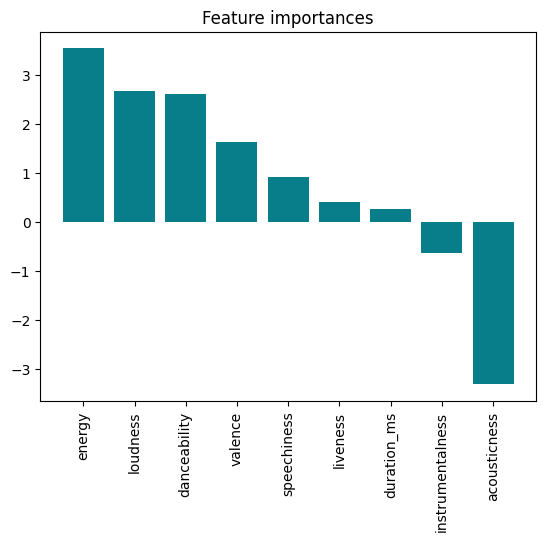

In [25]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

In [26]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['0', '1'],
    mode='classification'
)

In [27]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[0], 
    predict_fn=pipeline.predict_proba
)

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [28]:
exp.show_in_notebook(show_table=True)

We will test the model on two additional playlists.  First is Spotify's own "Songs to Sing in the Shower" playlist consisting of 200 songs. Following that will be Max Richter's classical-themed "Kitchen Playlist."

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

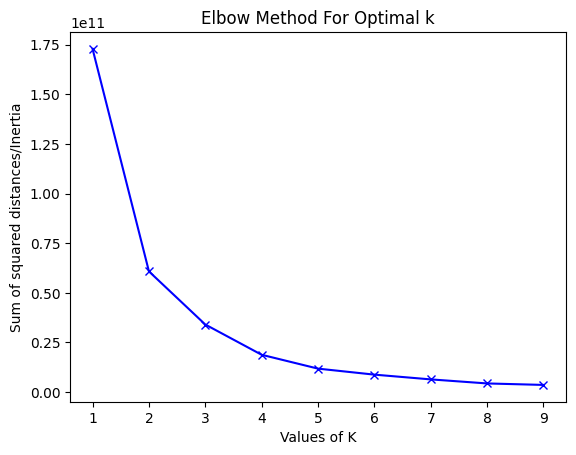

In [29]:
df_shower = pd.read_csv('showersongs.csv')
df_shower = df_shower.drop(['popularity', 'Unnamed: 0'], axis=1)
X_shower = df_shower.select_dtypes(np.number)
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_shower)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
cluster_pipeline3 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
cluster_pipeline3.fit(X_shower)

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

In [31]:
cluster_labels3 = cluster_pipeline3.predict(X_shower)
df_shower['cluster'] = cluster_labels3
df_shower['cluster'].value_counts()

0    147
1     53
Name: cluster, dtype: int64

In [32]:
pca_pipeline3 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding3 = pca_pipeline3.fit_transform(X_shower)
projection3 = pd.DataFrame(columns=['x', 'y'], data=song_embedding3)
projection3['title'] = df_shower['track_name']
projection3['artist'] = df_shower['artist_name']
projection3['cluster'] = df_shower['cluster']
fig3 = px.scatter(projection3, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig3.show()

Although there are less data points here, a two-cluster model seems to work best.

In [33]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df_shower.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster'], axis=1)
predictor_y = df_shower.cluster

# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
pipeline = make_pipeline(scaler, logreg)
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9622641509433962
Test Score:  0.9024390243902439


In [34]:
print("Training Metrics")
print(print_metrics(y_train, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.8461538461538461
Recall Score: 1.0
Accuracy Score: 0.9466666666666667
F1 Score: 0.9166666666666666
None


Testing Metrics
Precision Score: 0.5294117647058824
Recall Score: 1.0
Accuracy Score: 0.84
F1 Score: 0.6923076923076924
None


In [35]:
print("Confusion Matrices - Training and Test Sets")
plot_confusion_matrix(pipeline, X_train, y_train, cmap=plt.cm.Blues, values_format='.3g')
plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

Confusion Matrices - Training and Test Sets


NameError: name 'plot_confusion_matrix' is not defined

In [36]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

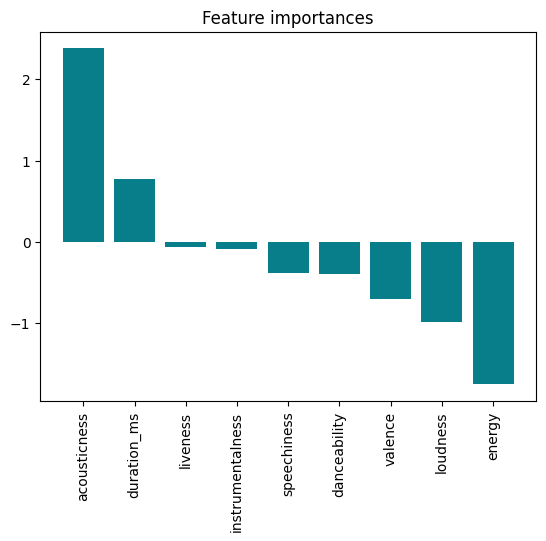

In [37]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

Despite the differences, our feature importances remain similar.

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

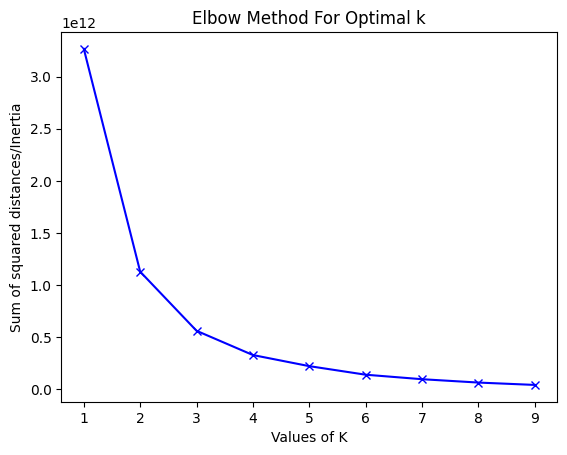

In [38]:
df_max = pd.read_csv('maxrichter.csv')
df_max = df_max.drop(['popularity', 'Unnamed: 0'], axis=1)
X_max = df_max.select_dtypes(np.number)
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_max)
 sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [39]:
cluster_pipeline4 = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])
cluster_pipeline4.fit(X_max)

/Users/shashankbangera/anaconda3/envs/spotify_recsys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=2))])

In [40]:
cluster_labels4 = cluster_pipeline4.predict(X_max)
df_max['cluster'] = cluster_labels4
df_max['cluster'].value_counts()

0    60
1    18
Name: cluster, dtype: int64

In [41]:
pca_pipeline4 = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding4 = pca_pipeline4.fit_transform(X_max)
projection4 = pd.DataFrame(columns=['x', 'y'], data=song_embedding4)
projection4['title'] = df_max['track_name']
projection4['artist'] = df_max['artist_name']
projection4['cluster'] = df_max['cluster']
fig4 = px.scatter(projection4, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title', 'artist'])
fig4.show()

In [42]:
# Creating x and y variables, keeping numerical features only 
predictor_x = df_max.drop(columns=['track_name', 'album', 'artist_name', 'release_date', 'tempo', 'cluster'], axis=1)
predictor_y = df_max.cluster

# Creating train and test sets, scaling and using SMOTE to adjust for imbalanced samples
X_train, X_test, y_train, y_test = train_test_split(predictor_x, predictor_y, test_size=.25,  random_state=42)
scaler = StandardScaler()

# Using Logistic Regression in pipeline to fit resampled sets
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
pipeline = make_pipeline(scaler, logreg)
pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
test_pred = pipeline.predict(X_test)

# ROC AUC score and classification metrics followed by visualized confusion matrix
train_score = roc_auc_score(y_train, train_pred)
test_score = roc_auc_score(y_test, test_pred)
print("Training Score: ", train_score)
print("Test Score: ", test_score)

Training Score:  0.9659090909090909
Test Score:  0.9375


In [43]:
print("Training Metrics")
print(print_metrics(y_train, train_pred))
print('\n')
print("Testing Metrics")
print(print_metrics(y_test, test_pred))

Training Metrics
Precision Score: 0.8235294117647058
Recall Score: 1.0
Accuracy Score: 0.9482758620689655
F1 Score: 0.9032258064516129
None


Testing Metrics
Precision Score: 0.6666666666666666
Recall Score: 1.0
Accuracy Score: 0.9
F1 Score: 0.8
None


In [44]:
print("Confusion Matrices - Training and Test Sets")
plot_confusion_matrix(pipeline, X_train, y_train, cmap=plt.cm.Blues, values_format='.3g')
plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues, values_format='.3g')

Confusion Matrices - Training and Test Sets


NameError: name 'plot_confusion_matrix' is not defined

In [45]:
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

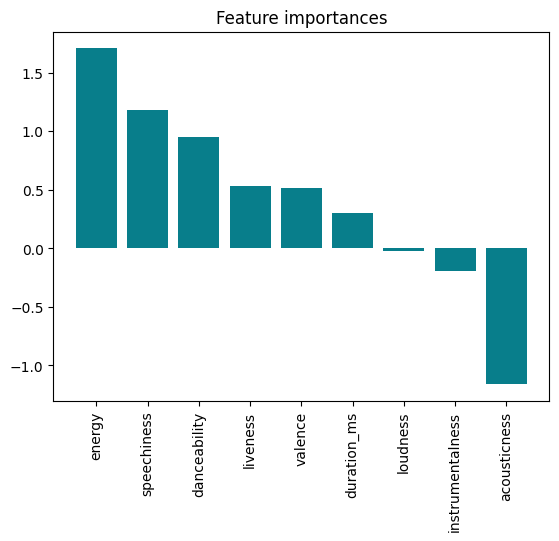

In [46]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances', size=12)
plt.xticks(rotation='vertical')
plt.show()

There are slight differences in feature importance here; this playlist is much shorter however a content-based recommendation system should still work despite the difference in recommended clusters.